# Unsupervised Machine Learning - Moosic Playlists

using MKMeans by sklearn

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(transform_output='pandas')

import spotipy
import pickle
from spotify_api import spotify_gen_object, token

import openai

from keys import client_username, openai_token



## Getting started on a 10-song database

In [4]:
#  Import and Clean data
songs = pd.read_csv("2_spotify_10_songs.csv")
songs.columns = songs.columns.str.strip()
songs

,song_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
0,My Band ...,D12,0.851,0.84900,1,-3.383,0,0.0828,0.49700,0.000002,0.1160,0.8440,120.014,298773,4,4XHQyvbrBsQaaBUW1VvmsL,https://open.spotify.com/track/4XHQyvbrBsQaaBU...
1,The Real Slim Shady ...,Eminem,0.949,0.66100,5,-4.244,0,0.0572,0.03020,0.000000,0.0454,0.7600,104.504,284200,4,3yfqSUWxFvZELEM4PmlwIR,https://open.spotify.com/track/3yfqSUWxFvZELEM...
2,Águas De Março ...,Antônio Carlos Jobim,0.642,0.33900,3,-15.503,1,0.1400,0.85400,0.000000,0.1050,0.4910,143.418,212400,4,1y7OxO5i6sfrHXAmUM77YG,https://open.spotify.com/track/1y7OxO5i6sfrHXA...
3,The Girl From Ipanema ...,Stan Getz,0.641,0.14000,8,-16.790,1,0.0390,0.86700,0.001660,0.1050,0.3880,129.318,317987,4,3898C4AbdbptwYet6547e5,https://open.spotify.com/track/3898C4AbdbptwYe...
4,"Paint It, Black ...",The Rolling Stones,0.464,0.79500,1,-9.267,1,0.0926,0.04930,0.002440,0.3990,0.6120,158.691,202267,4,63T7DJ1AFDD6Bn8VzG6JE8,https://open.spotify.com/track/63T7DJ1AFDD6Bn8...
5,Sultans Of Swing ...,Dire Straits,0.733,0.79400,5,-10.023,1,0.0307,0.06140,0.036700,0.3300,0.9310,148.174,348624,4,6cr6UDpkjEaMQ80OjWqEBQ,https://open.spotify.com/track/6cr6UDpkjEaMQ80...
6,Space Raiders - Charlotte de Witte Remix ...,Eats Everything,0.749,0.73100,4,-10.865,1,0.1080,0.00314,0.867000,0.1110,0.0598,131.997,438720,4,4F8OK7mNa51mKqgHqWQiYm,https://open.spotify.com/track/4F8OK7mNa51mKqg...
7,In Silence ...,Amelie Lens,0.736,0.84500,1,-12.017,1,0.0377,0.00548,0.901000,0.1110,0.1980,128.009,393740,4,2vfSCFvMbpf4hwxt22Wx7b,https://open.spotify.com/track/2vfSCFvMbpf4hwx...
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and ...",Johannes Brahms,0.184,0.00833,3,-33.503,1,0.0519,0.98900,0.596000,0.1040,0.2110,61.541,109800,3,59cPOVxrn3Yjwydl1pullI,https://open.spotify.com/track/59cPOVxrn3Yjwyd...
9,Nocturne en mi bémol majeur opus 9 n°2: Ballad...,Frédéric Chopin,0.387,0.04510,3,-24.698,1,0.0364,0.99000,0.913000,0.1120,0.0710,61.494,268427,4,7n92QzQomRCLlciO14X0kd,https://open.spotify.com/track/7n92QzQomRCLlci...


###  Music Intuition - Choose Features
Don't go with ALL features. Which features make sense for clustering such songs?

- danceability: rather not, as it is unfittingly high with rap songs
- energy: yes
- key: not so important
- mode: yes, as minor-songs tend to more sad, but here doesnt seem to fit, as most songs are in mayor except the rap songs, no no.
- loudness: does depends on the recording, so not relevant here
- speechiness: to distinguish podcast etc; not relevant here
- acousticness: seems important to dinstuing e.g. classical music
- instrumentalness: yes, to distinguish rap,etc
- liveness: no live songs here, right? maybe *paint it black*`? also, values dont differ that much, so no
- valence: higher values mean more positive songs. seems relevant. interesting, that classic and electronic songs are sad :O
- tempo: important for a song feeling continuity in a playlist 
- duration_ms: song length. does not matter here; rather for hours-long tracks in bigger samples
- time_signature: does not differ much. = Takt?

names and ids are excluded in the model

It seems there are 5 genres of songs (rap, bossanova, rock, electronic, classic), so I will try to cluster in 5 categories
 

In [124]:
chosen_metrics = ["energy", "acousticness", "instrumentalness", "valence", "tempo"]

### ML Model with KMeans

In [135]:
songs_sel = songs.copy()[chosen_metrics]

songs_model_kmeans = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans.fit(songs_sel)

songs_sel["group"] = songs_model_kmeans.labels_
songs_sel

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,energy,acousticness,instrumentalness,valence,tempo,group
0,0.84900,0.49700,0.000002,0.8440,120.014,4
1,0.66100,0.03020,0.000000,0.7600,104.504,3
2,0.33900,0.85400,0.000000,0.4910,143.418,2
3,0.14000,0.86700,0.001660,0.3880,129.318,0
4,0.79500,0.04930,0.002440,0.6120,158.691,2
5,0.79400,0.06140,0.036700,0.9310,148.174,2
6,0.73100,0.00314,0.867000,0.0598,131.997,0
7,0.84500,0.00548,0.901000,0.1980,128.009,0
8,0.00833,0.98900,0.596000,0.2110,61.541,1
9,0.04510,0.99000,0.913000,0.0710,61.494,1


### Scaling

Using a Scaler to transform the data might help the model to generate more useful categories, due to dealing with outliers and assumptions like normality, etc. Different Scalers bring different consequences, though - see [Notebook](WBS Coding School\7. Unsupervised ML\Challenges\6_2_scaling_data.ipynb) 

In [128]:
songs_sel = songs.copy()[chosen_metrics]

scaler_MinMax = MinMaxScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/
scaler_Standard = StandardScaler().set_output(transform="pandas")
scaler_Robust = RobustScaler().set_output(transform="pandas")
scaler_QuanTrans = QuantileTransformer().set_output(transform="pandas")
scaler_PowerTrans = PowerTransformer().set_output(transform="pandas")

# Scale the foods_df DataFrame
songs_scaled1 = scaler_MinMax.fit_transform(songs_sel)
songs_scaled2 = scaler_Standard.fit_transform(songs_sel)
songs_scaled3 = scaler_Robust.fit_transform(songs_sel)
songs_scaled4 = scaler_QuanTrans.fit_transform(songs_sel)
songs_scaled5 = scaler_PowerTrans.fit_transform(songs_sel)
songs_scaled1, songs_scaled2

(     energy  acousticness  instrumentalness   valence     tempo
 0  1.000000      0.500436          0.000002  0.900138  0.602076
 1  0.776369      0.027420          0.000000  0.803719  0.442503
 2  0.393341      0.862189          0.000000  0.494949  0.842866
 3  0.156625      0.875362          0.001818  0.376722  0.697799
 4  0.935766      0.046775          0.002673  0.633838  1.000000
 5  0.934576      0.059036          0.040197  1.000000  0.891797
 6  0.859636      0.000000          0.949617  0.000000  0.725362
 7  0.995242      0.002371          0.986857  0.158632  0.684332
 8  0.000000      0.998987          0.652793  0.173554  0.000484
 9  0.043739      1.000000          1.000000  0.012856  0.000000,
      energy  acousticness  instrumentalness   valence     tempo
 0  0.992687      0.146786         -0.816077  1.270021  0.040646
 1  0.424153     -0.952202         -0.816082  0.994657 -0.445036
 2 -0.549612      0.987271         -0.816082  0.112834  0.773521
 3 -1.151411      1.0178

Apply the model again to cluster the songs

In [129]:
songs_model_kmeans1 = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans1.fit(songs_scaled1)
songs_sel["Scale_MinMax"] = songs_model_kmeans1.labels_

songs_model_kmeans2 = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans2.fit(songs_scaled2)
songs_sel["Scale_Standard"] = songs_model_kmeans2.labels_

songs_model_kmeans3 = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans3.fit(songs_scaled3)
songs_sel["Scale_Robust"] = songs_model_kmeans3.labels_

songs_model_kmeans4 = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans4.fit(songs_scaled4)
songs_sel["Scale_QuantTrans"] = songs_model_kmeans4.labels_

songs_model_kmeans5 = KMeans(n_clusters = 5, n_init = 'auto', random_state = 87)
songs_model_kmeans5.fit(songs_scaled5)
songs_sel["Scale_PowerTrans"] = songs_model_kmeans5.labels_

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

In [130]:
pd.concat([songs[["song_name", "artist"]],songs_sel], axis=1)

,song_name,artist,energy,acousticness,instrumentalness,valence,tempo,Scale_MinMax,Scale_Standard,Scale_Robust,Scale_QuantTrans,Scale_PowerTrans
0,My Band ...,D12,0.84900,0.49700,0.000002,0.8440,120.014,4,4,4,4,4
1,The Real Slim Shady ...,Eminem,0.66100,0.03020,0.000000,0.7600,104.504,3,4,4,4,4
2,Águas De Março ...,Antônio Carlos Jobim,0.33900,0.85400,0.000000,0.4910,143.418,1,1,3,3,1
3,The Girl From Ipanema ...,Stan Getz,0.14000,0.86700,0.001660,0.3880,129.318,1,1,3,3,1
4,"Paint It, Black ...",The Rolling Stones,0.79500,0.04930,0.002440,0.6120,158.691,3,3,2,1,3
5,Sultans Of Swing ...,Dire Straits,0.79400,0.06140,0.036700,0.9310,148.174,3,3,2,1,3
6,Space Raiders - Charlotte de Witte Remix ...,Eats Everything,0.73100,0.00314,0.867000,0.0598,131.997,0,0,0,0,0
7,In Silence ...,Amelie Lens,0.84500,0.00548,0.901000,0.1980,128.009,0,0,0,0,0
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and ...",Johannes Brahms,0.00833,0.98900,0.596000,0.2110,61.541,2,2,1,2,2
9,Nocturne en mi bémol majeur opus 9 n°2: Ballad...,Frédéric Chopin,0.04510,0.99000,0.913000,0.0710,61.494,2,2,1,2,2


All models work quiet well in catching the genre, but most get rap wrong. The Robust Model did it perfectly!

### Find the right number of clusters

there are two ways:

#### 1. The Elbow Method
calculate inertia for each number of possible clusters, plot it and see were the curve flattens - look for the elbow

In [145]:
songs_sel = songs.copy()[chosen_metrics]
scalerRobust = RobustScaler().set_output(transform="pandas")
songs_scaled = scalerRobust.fit_transform(songs_sel)

inertia_list = []

for i in range(1,10):
    myKMeans = KMeans(n_clusters=i, random_state=123, n_init="auto")
    myKMeans.fit(songs_scaled)
    inertia_list.append(round(myKMeans.inertia_))

inertia_list

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

[21, 9, 5, 3, 1, 1, 0, 0, 0]

c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


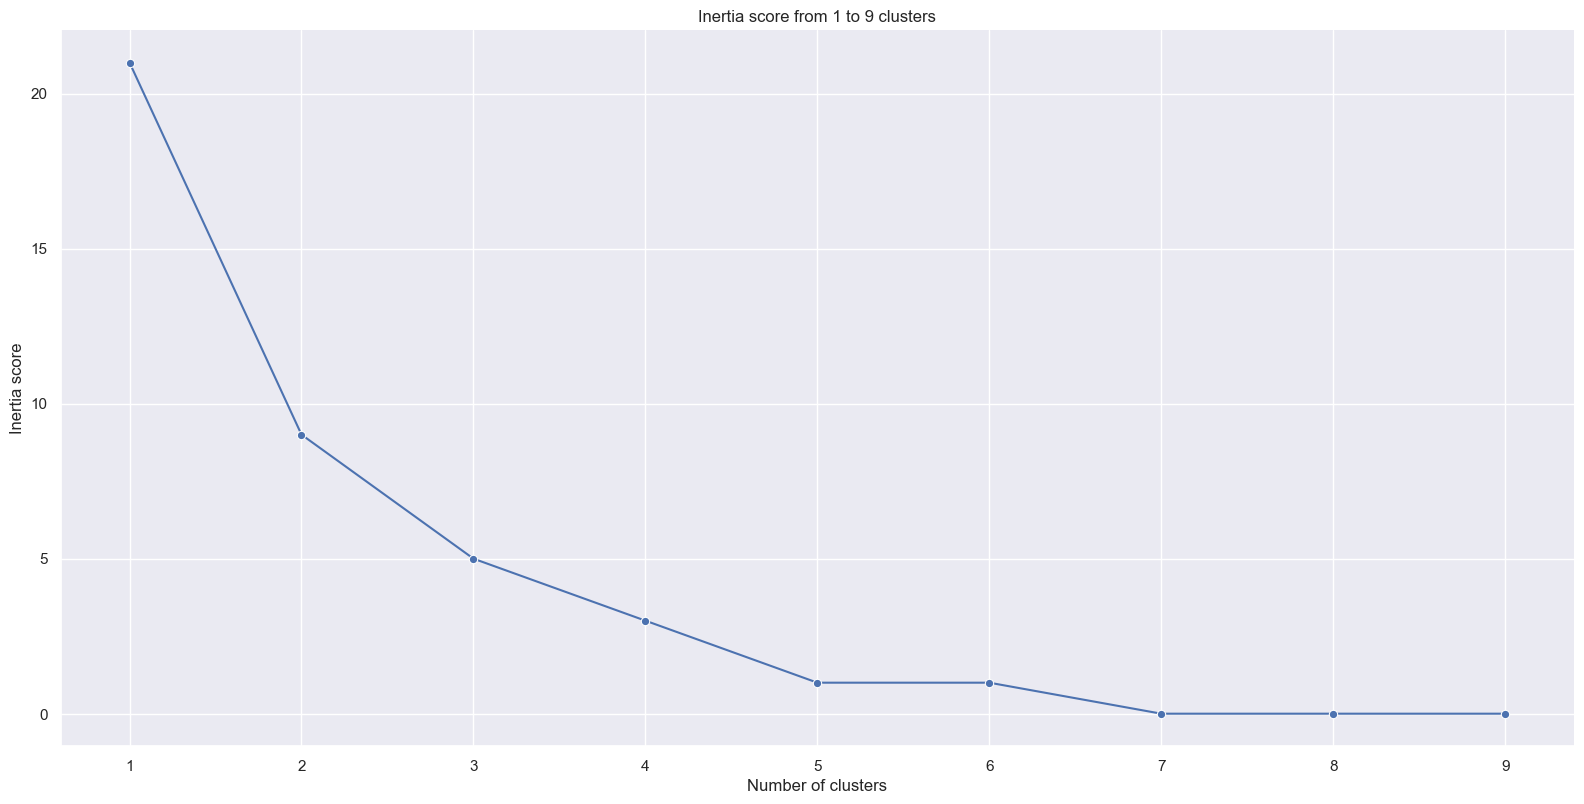

In [149]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1,10),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia score from 1 to 9 clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia score")
);

here it looks like, the elbow is between 2 and 3. Ergo, there would 2 playlists gathered from the distance between each songs metric

#### The Silhouette Score
using KMeans `silhouette_score` function

In [156]:
songs_sel = songs.copy()[chosen_metrics]
scalerRobust = RobustScaler().set_output(transform="pandas")
songs_scaled = scalerRobust.fit_transform(songs_sel)

seed = 123
max_k = 10

# Create an empty list to store the silhouette scores
sil_scores = []

for j in range(2, max_k):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=j,
                    n_init="auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(songs_scaled)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(songs_scaled, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


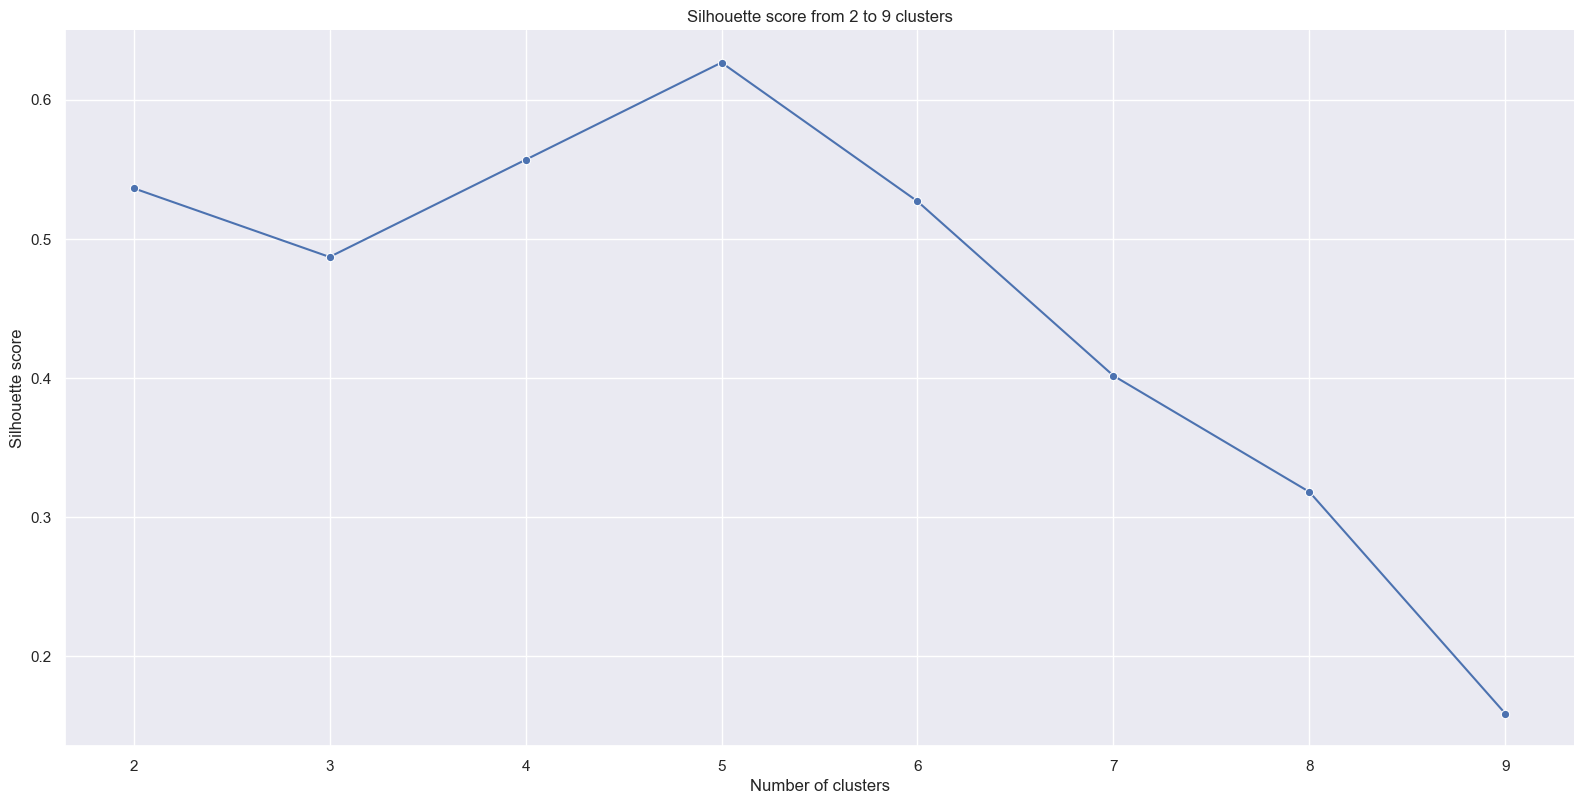

In [157]:
sns.set_theme(style='darkgrid')

(
sns.relplot(y=sil_scores,
            x=range(2,max_k),
            kind='line',
            marker='o',
            height = 8,
            aspect=2)
.set(title=f"Silhouette score from 2 to {max_k-1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

here it looks like 5 clusters is the way to go. this is what i said intuitivly, earlier, as well. It remains the same with different random seeds.

---
## Run the Model on a 5000-song database

In [3]:
songs_df = pd.read_csv("3_spotify_5000_songs.csv")
songs_df.columns = songs_df.columns.str.strip()

### Explore the dataset

Questions & Decisions:
1. Are there podcasts or non-song audio files? 
    - longer songs are not pocasts or soever. -> speechiness excluded
    - Yet, +15min songs seem to be classic songs. As classic songs should not be clustered differently because of lenth, I will leave *duration* out of the *metrics_sel* 
2. keys and modes: In this bigger dataset, it may seems useful to differentiate between modes (but not keys) because of mood
3. Live-Songs: I wouldn mind having live and not-live songs mixed in my playlist. In fact, thats often the case in spotifies "list of the week". First try without including. 
5. danceability: rather not, as it is unfittingly high with rap songs
6. loudness: does depends on the recording, so not relevant here
7. time_signature: does not differ much. = Takt?

In [4]:
# Define features/metrics
chosen_metrics = ["energy", "acousticness", "instrumentalness", "valence", "tempo", "mode"]
songs_df_sel = songs_df.copy()[chosen_metrics]

In [6]:
songs_df["duration_min"] = (songs_df["duration_ms"]/1000/60).round(1)
songs_df.sort_values("duration_min", ascending=0).head(30)

songs_df.sample(10)

,Unnamed: 0,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,duration_min
1589,1589,Single Ladies (Put a Ring on It) ...,Beyoncé,0.426,0.584,1,-5.293,1,0.2960,0.038300,0.000000,0.1880,0.272,193.437,,193213,4,5R9a4t5t5O0IsznsrKPVro,https://open.spotify.com/track/5R9a4t5t5O0Iszn...,3.2
1450,1450,You Gotta Be ...,Des'ree,0.623,0.669,0,-9.985,1,0.0412,0.211000,0.000003,0.1110,0.492,94.028,,245200,4,6CU0zWIWVTEnmWpSjVHM93,https://open.spotify.com/track/6CU0zWIWVTEnmWp...,4.1
2184,2184,All Mine ...,Kanye West,0.925,0.308,11,-6.562,0,0.3380,0.125000,0.000000,0.0933,0.265,122.099,,145507,4,3qnoOm4fwZPBS116f5hpgF,https://open.spotify.com/track/3qnoOm4fwZPBS11...,2.4
4112,4112,Sunrise Over Locus Mortis - Studio ...,Darkthrone,0.147,0.932,4,-7.912,0,0.0988,0.000001,0.808000,0.3430,0.158,138.769,,210507,3,2zDII2yGOUCdwlkfMq2ruB,https://open.spotify.com/track/2zDII2yGOUCdwlk...,3.5
3328,3328,Eso En 4 No Se Ve (feat. Nejo Y Dalmata & Luig...,J Alvarez,0.840,0.706,8,-8.413,1,0.1340,0.444000,0.001720,0.3270,0.841,91.043,,271987,4,3AiSzVa7e1thtKKnJfs03I,https://open.spotify.com/track/3AiSzVa7e1thtKK...,4.5
4138,4138,March to Die ...,Possessed,0.363,0.963,6,-4.596,1,0.1990,0.000234,0.109000,0.0991,0.139,90.909,,192187,4,7zmfD65SIsHr4yNSrEsVQY,https://open.spotify.com/track/7zmfD65SIsHr4yN...,3.2
4332,4332,Into The Necrosphere ...,Broken Hope,0.167,0.887,1,-11.326,1,0.2120,0.000190,0.865000,0.1120,0.118,77.281,,187827,4,35FxPb9nspwHE7aN9kIjVH,https://open.spotify.com/track/35FxPb9nspwHE7a...,3.1
1745,1745,Something Just Like This ...,The Chainsmokers,0.607,0.649,11,-6.695,0,0.0362,0.030600,0.000025,0.1740,0.505,102.996,,247627,4,1dNIEtp7AY3oDAKCGg2XkH,https://open.spotify.com/track/1dNIEtp7AY3oDAK...,4.1
4042,4042,Ceremony Of Shiva ...,Behemoth,0.218,0.884,10,-3.979,1,0.0710,0.000004,0.588000,0.1890,0.122,86.790,,212764,4,57A2NvwWiyV3m5rYttr7QX,https://open.spotify.com/track/57A2NvwWiyV3m5r...,3.5
4324,4324,The Dead Half ...,Broken Hope,0.405,0.755,2,-12.772,1,0.0536,0.241000,0.896000,0.5560,0.435,109.759,,152667,4,5wwgYAs0uuIcV5bOzdUAaD,https://open.spotify.com/track/5wwgYAs0uuIcV5b...,2.5


### clickable html link for easy listening

In [ ]:
# make clickable link for easy listening
from IPython.display import HTML
songs_df_html = HTML(songs_df.to_html(render_links=True, escape=False))

In [ ]:
# Alternative way
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)
test = songs_df.style.format({'html': make_clickable})

# both way lose the pandas framework, though

### Define Scaling method

In [6]:
# Define various scaling methods
scaler_MinMax = MinMaxScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/
scaler_Standard = StandardScaler().set_output(transform="pandas")
scaler_Robust = RobustScaler().set_output(transform="pandas")
scaler_QuanTrans = QuantileTransformer(n_quantiles = 5, random_state = 123).set_output(transform="pandas")
scaler_PowerTrans = PowerTransformer().set_output(transform="pandas")

In [5]:
# Run Robust Scaling on the dataset
scalerRobust = RobustScaler().set_output(transform="pandas")
songs_scaled = scalerRobust.fit_transform(songs_df_sel)

### Find the right number of clusters

using the elbow and silhouette techniques

In [8]:
# Nr of k. with 5000 songs, compare up to 200 clusters/playlists (each 25 songs long) would be a good number. however, it takes a while to compute
max_k = 200
rand = 123

inertia_list = []

for i in range(1,max_k):
    myKMeans = KMeans(n_clusters=i, random_state=rand, n_init="auto")
    myKMeans.fit(songs_scaled)
    inertia_list.append(round(myKMeans.inertia_))

c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


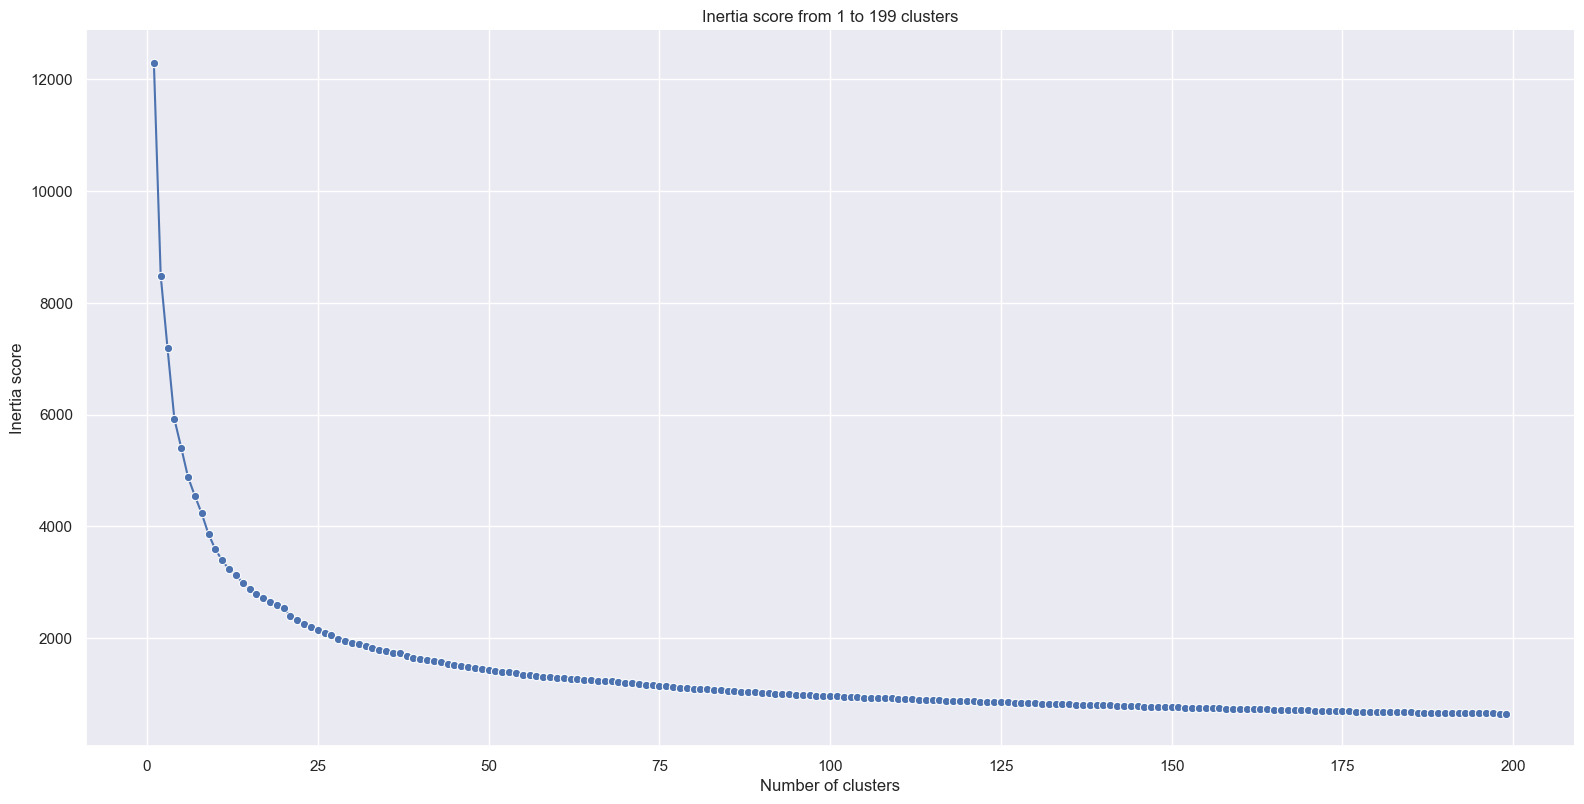

In [9]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1,max_k),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia score from 1 to {max_k-1} clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia score")
);

using k=50, the elbow is around 10, i would say. also with different random_seeds
using k=200, the elbow is around 20!  - thats quiet arbitryry.

Lets see what the Silouette Technique produces

In [10]:
seed = 123
max_k = 60 # 60 possible clusters is enough, as it takes a long time

# Create an empty list to store the silhouette scores
sil_scores = []

for j in range(2, max_k):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=j,
                    n_init="auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(songs_scaled)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(songs_scaled, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nix-n\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


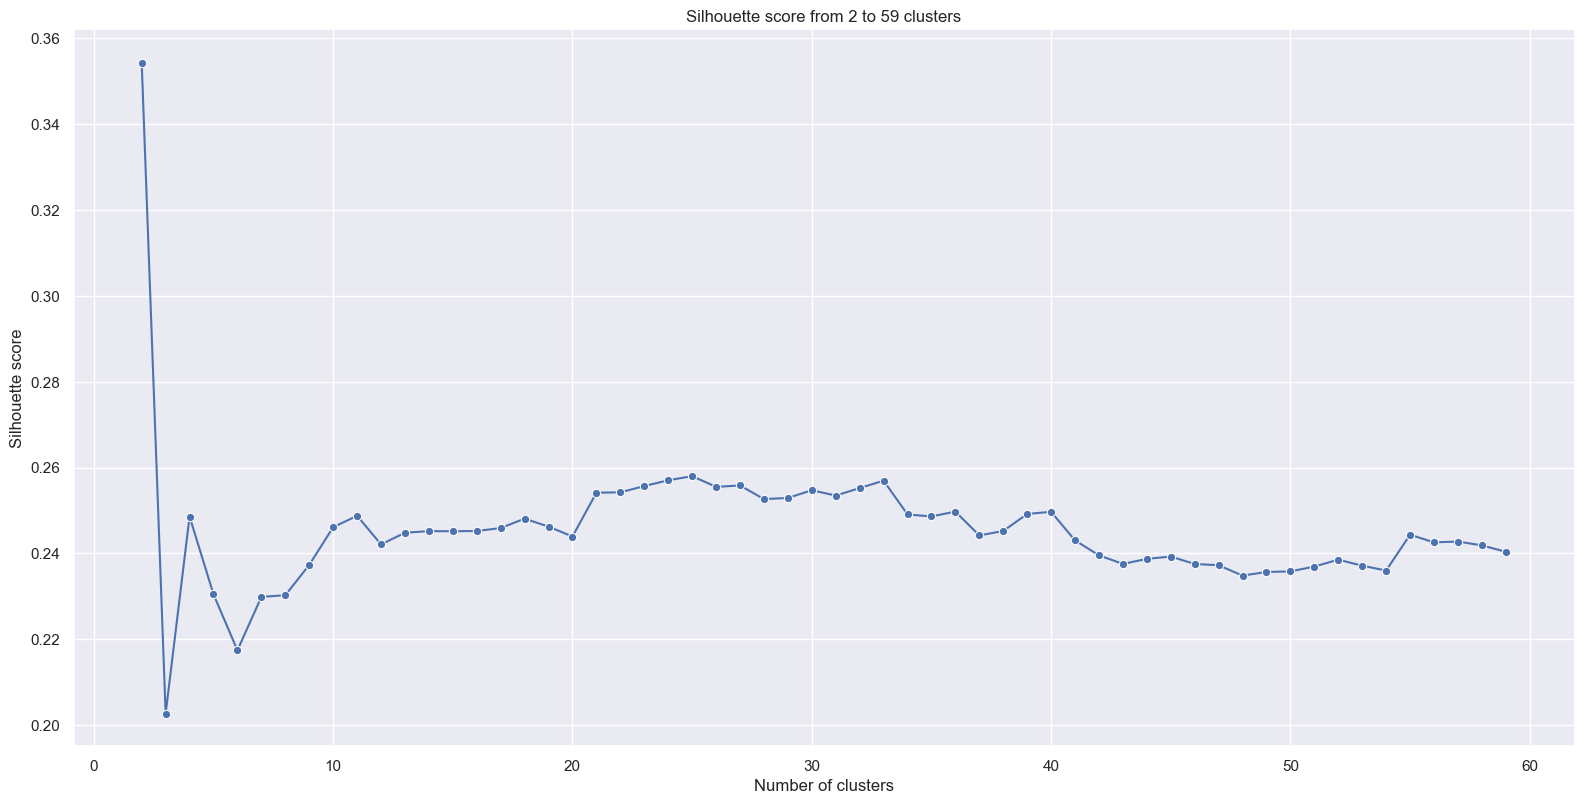

In [11]:
sns.set_theme(style='darkgrid')

(
sns.relplot(y=sil_scores,
            x=range(2,max_k),
            kind='line',
            marker='o',
            height = 8,
            aspect=2)
.set(title=f"Silhouette score from 2 to {max_k-1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

### Run the usML Model

In [ ]:
# define and run model
songs_model_kmeans = KMeans(n_clusters = 25, random_state=123, n_init="auto")
songs_model_kmeans.fit(songs_scaled)
songs_scaled["cluster"] = pd.Series(songs_model_kmeans.labels_)

# new Dataframe with non-scaled data, titles and cluster
songs_df_clustered = pd.concat([songs_scaled["cluster"],songs_df[["name", "artist"] + chosen_metrics + ["id", "html"]]], axis=1)

# Clean 
songs_df_clustered.name = songs_df_clustered.name.str.strip()
songs_df_clustered.artist = songs_df_clustered.artist.str.strip()

### Explore the clustered song db

In [8]:
songs_df_clustered.sort_values("cluster")

,cluster,name,artist,energy,acousticness,instrumentalness,valence,tempo,mode,id,html
749,0,All Night ...,The Vamps,0.775,0.002510,0.000000,0.4580,144.945,1,1yNyoWWWikbLhwIGWjZuDW,https://open.spotify.com/track/1yNyoWWWikbLhwI...
3805,0,Climate Controller ...,Nocturnus,0.756,0.000523,0.052600,0.5230,154.667,1,0QOxeiPiVep0vNZisCbDX9,https://open.spotify.com/track/0QOxeiPiVep0vNZ...
3801,0,Testimony ...,Vader,0.981,0.000218,0.200000,0.0388,173.543,1,5EwUqcFzbSGGRPP64bKcGn,https://open.spotify.com/track/5EwUqcFzbSGGRPP...
3799,0,Dark Transmission ...,Vader,0.901,0.000119,0.017700,0.2700,160.171,1,1tQVofEENZ5srgkPVk3tTn,https://open.spotify.com/track/1tQVofEENZ5srgk...
3796,0,Final Massacre ...,Vader,0.744,0.000103,0.064600,0.1470,199.387,1,5YcjcQqhrsMNwjafO161pY,https://open.spotify.com/track/5YcjcQqhrsMNwja...
...,...,...,...,...,...,...,...,...,...,...,...
4848,24,So wie Du warst ...,Unheilig,0.759,0.006450,0.000451,0.3130,115.521,1,3vm2VlmCikwjWKpy8cwZ9d,https://open.spotify.com/track/3vm2VlmCikwjWKp...
1748,24,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,0.451,0.063100,0.000013,0.0862,117.973,1,3NdDpSvN911VPGivFlV5d0,https://open.spotify.com/track/3NdDpSvN911VPGi...
926,24,"Shout, Pts. 1 & 2 ...",The Isley Brothers,0.866,0.753000,0.000000,0.4160,138.630,1,2ZNTPtYmAhN9vCwnAgqKn1,https://open.spotify.com/track/2ZNTPtYmAhN9vCw...
5075,24,Still ...,Brian Courtney Wilson,0.531,0.514000,0.000000,0.3300,146.278,1,5vh7Na52Ql4IhJIbrtbHoQ,https://open.spotify.com/track/5vh7Na52Ql4IhJI...


In [101]:
stats = songs_df_clustered.groupby("cluster").agg({"cluster":"count", "energy":"mean", "acousticness":"mean", "acousticness":"mean","instrumentalness":"mean", "valence":"mean", "tempo":"mean", "mode":"mean"})#.sort_values("cluster")
stats.rename(columns={"cluster":"cluster_count"}, inplace=True) 
stats

,cluster_count,energy,acousticness,instrumentalness,valence,tempo,mode
cluster,,,,,,,
0,126,0.820222,0.052554,0.035724,0.366188,168.588238,1.000000
1,100,0.164032,0.878660,0.888460,0.199930,125.120780,0.000000
2,308,0.731500,0.168040,0.013792,0.676253,93.838942,0.000000
3,153,0.261644,0.803569,0.039568,0.357758,128.296582,0.915033
4,371,0.897792,0.011998,0.809995,0.235389,105.900216,1.000000
5,427,0.800314,0.088949,0.038238,0.751944,125.843681,1.000000
6,192,0.106329,0.939941,0.860151,0.119910,77.969583,1.000000
7,171,0.749228,0.278827,0.052049,0.796035,168.483199,1.000000
8,143,0.892545,0.015752,0.777259,0.270431,138.737042,0.000000


plot the distances on a heatmap:

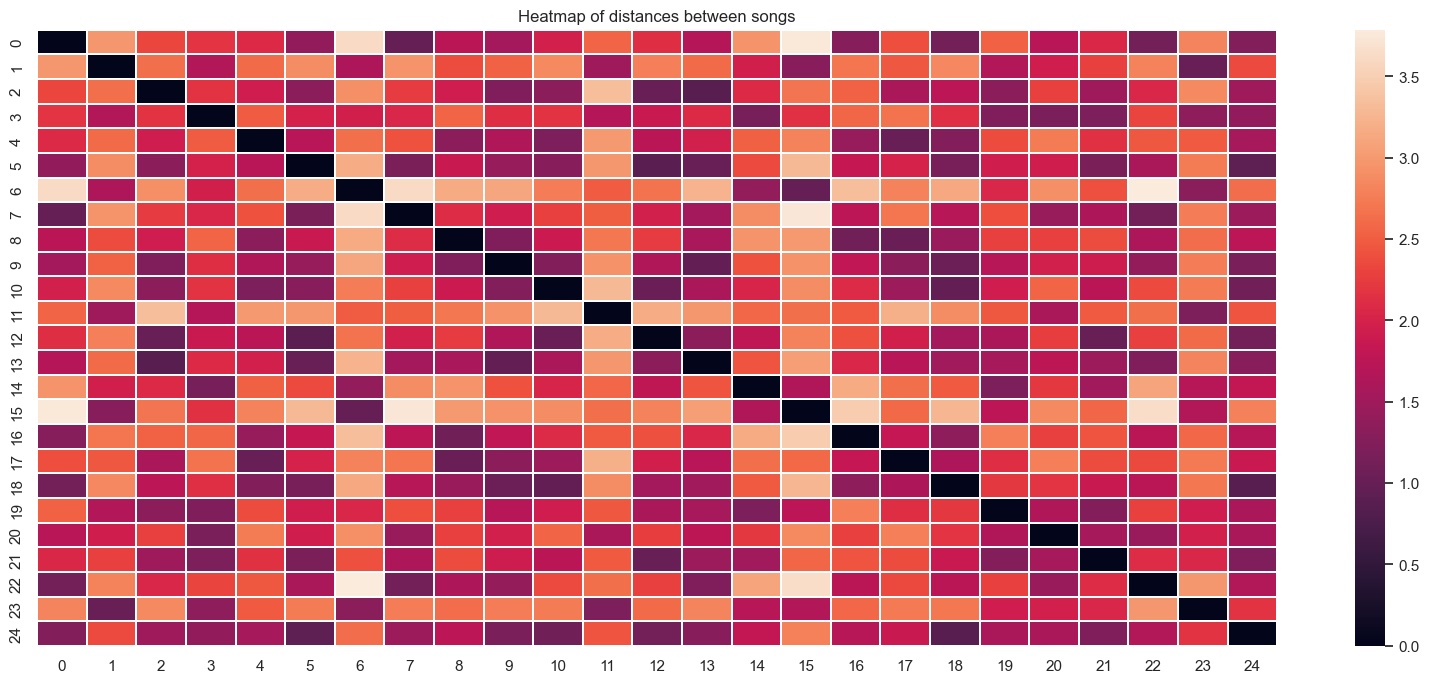

In [24]:
# the means should look quiet similiar to the centroids:
centroids = songs_model_kmeans.cluster_centers_

# Making the DataFrame for the Quantile heatmap
songs_df_distances = pd.DataFrame(pairwise_distances(pd.DataFrame(centroids)),
                                           index=pd.DataFrame(centroids).index,
                                           columns=pd.DataFrame(centroids).index)

# Heatmap plotting
fig, (ax1) = plt.subplots(1, figsize=(20, 8))
sns.heatmap(songs_df_distances, ax=ax1, linewidths=.2);
ax1.set_title('Heatmap of distances between songs')
plt.show()

## Improve the model

Ideas
- exclude metric outliers per cluster (silhouette oder centroids)
- redefine included metrics. E.g., include "danceblitity" and "loudness" 
- subcluster clusters - would also work for increasing number of playlist and reducing songs per playlist

### Silhoutte score to find distance of each item to its cluster

In [78]:
clusterer = KMeans(n_clusters=25, random_state=123)
cluster_labels = clusterer.fit_predict(songs_scaled)

silhouette_scores = silhouette_samples(songs_scaled, cluster_labels)
songs_df_clustered["sil_score"] = silhouette_scores

songs_df_clustered

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,cluster,name,artist,energy,acousticness,instrumentalness,valence,tempo,mode,id,html,sil_score
0,19,Se Eu Quiser Falar Com Deus,Gilberto Gil,0.25900,0.694,0.000059,0.3060,110.376,0,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...,0.535579
1,24,Saudade De Bahia,Antônio Carlos Jobim,0.39900,0.217,0.000002,0.6930,125.039,1,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...,0.590808
2,12,"Canta Canta, Minha Gente",Martinho Da Vila,0.73000,0.453,0.000063,0.9050,93.698,1,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,0.560561
3,3,Mulher Eu Sei,Chico César,0.05020,0.879,0.000041,0.5240,106.802,1,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...,0.594303
4,3,Rosa Morena,Kurt Elling,0.11900,0.916,0.000343,0.4020,120.941,1,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...,0.706103
...,...,...,...,...,...,...,...,...,...,...,...,...
5230,6,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.06940,0.917,0.715000,0.0655,87.906,1,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...,0.816272
5231,6,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.10100,0.855,0.426000,0.0355,83.134,1,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...,0.720568
5232,6,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.00093,0.951,0.969000,0.0344,71.573,1,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...,0.839846
5233,6,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.02080,0.883,0.505000,0.0591,67.109,1,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...,0.760259


In [111]:
# Statistics of each clusters feature 
songs_df_clustered.groupby("cluster")["sil_score"].describe().sort_values("cluster", ascending=False)

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
24,241.0,0.667668,0.075204,0.306402,0.622634,0.685795,0.725223,0.770060
23,131.0,0.669413,0.102671,0.199231,0.646413,0.703433,0.731507,0.768639
22,141.0,0.592122,0.070067,0.334684,0.548562,0.598497,0.648805,0.702729
21,218.0,0.538679,0.077632,0.250343,0.493172,0.556046,0.598413,0.660116
20,88.0,0.369397,0.080378,0.129917,0.306609,0.388845,0.429189,0.533471
19,167.0,0.483851,0.086868,0.269470,0.416528,0.498486,0.554867,0.626347
18,252.0,0.672943,0.063747,0.438402,0.644568,0.688180,0.720852,0.761879
17,141.0,0.618119,0.080630,0.345155,0.586573,0.641105,0.676496,0.715437
16,180.0,0.587718,0.083113,0.360937,0.527949,0.596640,0.661130,0.697700


In [ ]:
# This code provides a visualisation of the knives chart
# (printing Silhouette scores for all datapoints --> Silhouette Samples

songs_scaled_ex = songs_scaled.iloc[:,:-1]

def plot_silhouette_scores(k, features, sel_k = []):

    if sel_k == []:
        sel_k = list(range(k))

    kmeans = KMeans(n_clusters=k, random_state=123).fit(features)
    labels = kmeans.labels_
    score = silhouette_score(features, labels)

    # Compute silhouette scores for each sample
    sample_scores = silhouette_samples(features, labels)

    fig, ax = plt.subplots(figsize=(10,10))
    y_lower = 10
    cmap = get_cmap("viridis")

    for i in sel_k:
        # Aggregate the silhouette scores for samples belonging to the same cluster and sort them
        ith_cluster_silhouette_values = sample_scores[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 150

    ax.set_title("Silhouette Scores for Penguins Dataset with k = {}".format(k))
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the y-axis labels
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()



def plot_silhouette_scores_pres(k, features, sel_k = []):

    if sel_k == []:
        sel_k = list(range(k))

    kmeans = KMeans(n_clusters=k, random_state=123).fit(features)
    labels = kmeans.labels_
    score = silhouette_score(features, labels)

    # Compute silhouette scores for each sample
    sample_scores = silhouette_samples(features, labels)

    fig, ax = plt.subplots(figsize=(10,6))
    y_lower = 10
    cmap = get_cmap("viridis")

    for i in sel_k:
        # Aggregate the silhouette scores for samples belonging to the same cluster and sort them
        ith_cluster_silhouette_values = sample_scores[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cmap(float(i) / k)
        color = "#01AFD1"
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 100

    ax.set_yticks([])  # Clear the y-axis labels
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.tight_layout() 

    plt.grid(False)

    ax.patch.set_visible(False)

    # Remove spines and ticks
    ax = plt.gca()  # Get the current Axes instance on the current figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    plt.show()

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nix-n\AppData\Local\Temp\ipykernel_24308\2459440559.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


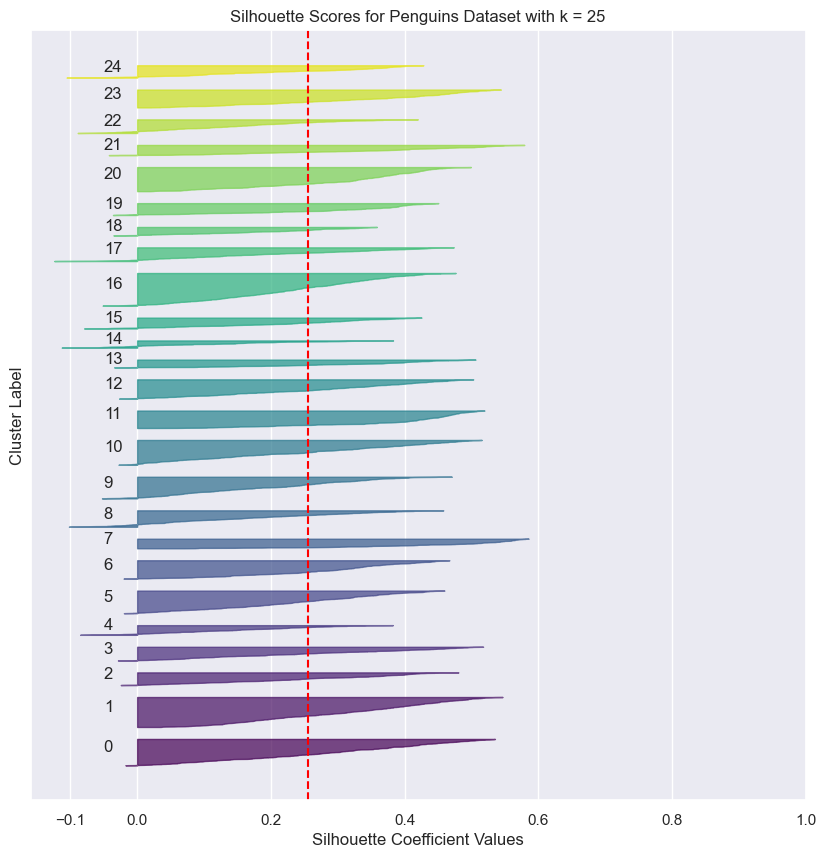

In [244]:
# Visualize the silhouette scores for different k values
plot_silhouette_scores(25, songs_scaled_ex)

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nix-n\AppData\Local\Temp\ipykernel_24308\2459440559.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


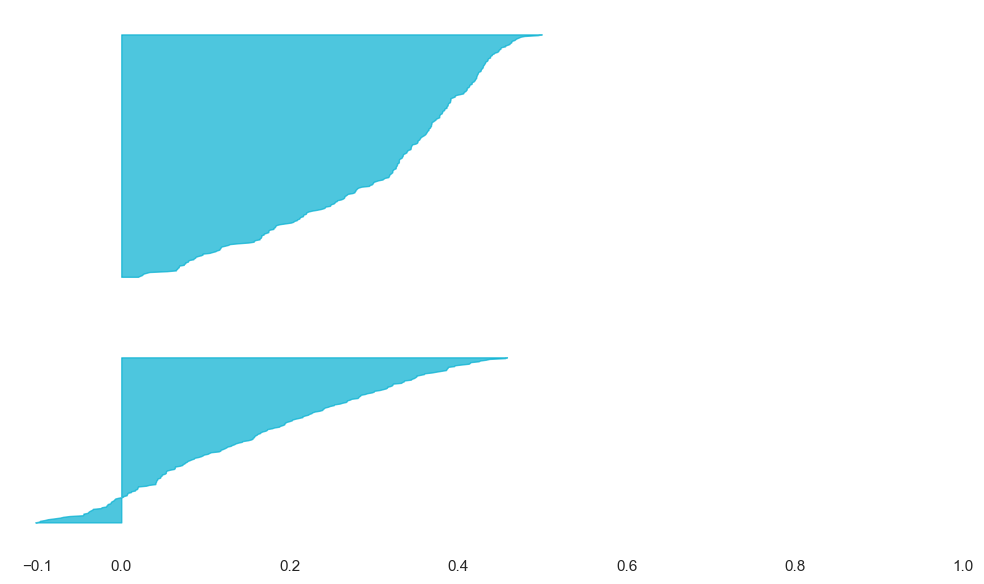

In [243]:
# Knife Plot for selected clusters to present
plot_silhouette_scores_pres(25, songs_scaled_ex, [8,20])

### Explore Metrics of one cluster (cluster 1)

In [71]:
# Scale data
scalerRobust = RobustScaler().set_output(transform="pandas")
cluster1_scaled = scalerRobust.fit_transform(songs_df_clustered.loc[songs_df_clustered.cluster == 1, chosen_metrics])

In [ ]:
# Elbow
max_k = 30
rand = 123

inertia_list = []

for i in range(1,max_k):
    myKMeans = KMeans(n_clusters=i, random_state=rand, n_init="auto")
    myKMeans.fit(cluster1_scaled)
    inertia_list.append(round(myKMeans.inertia_))

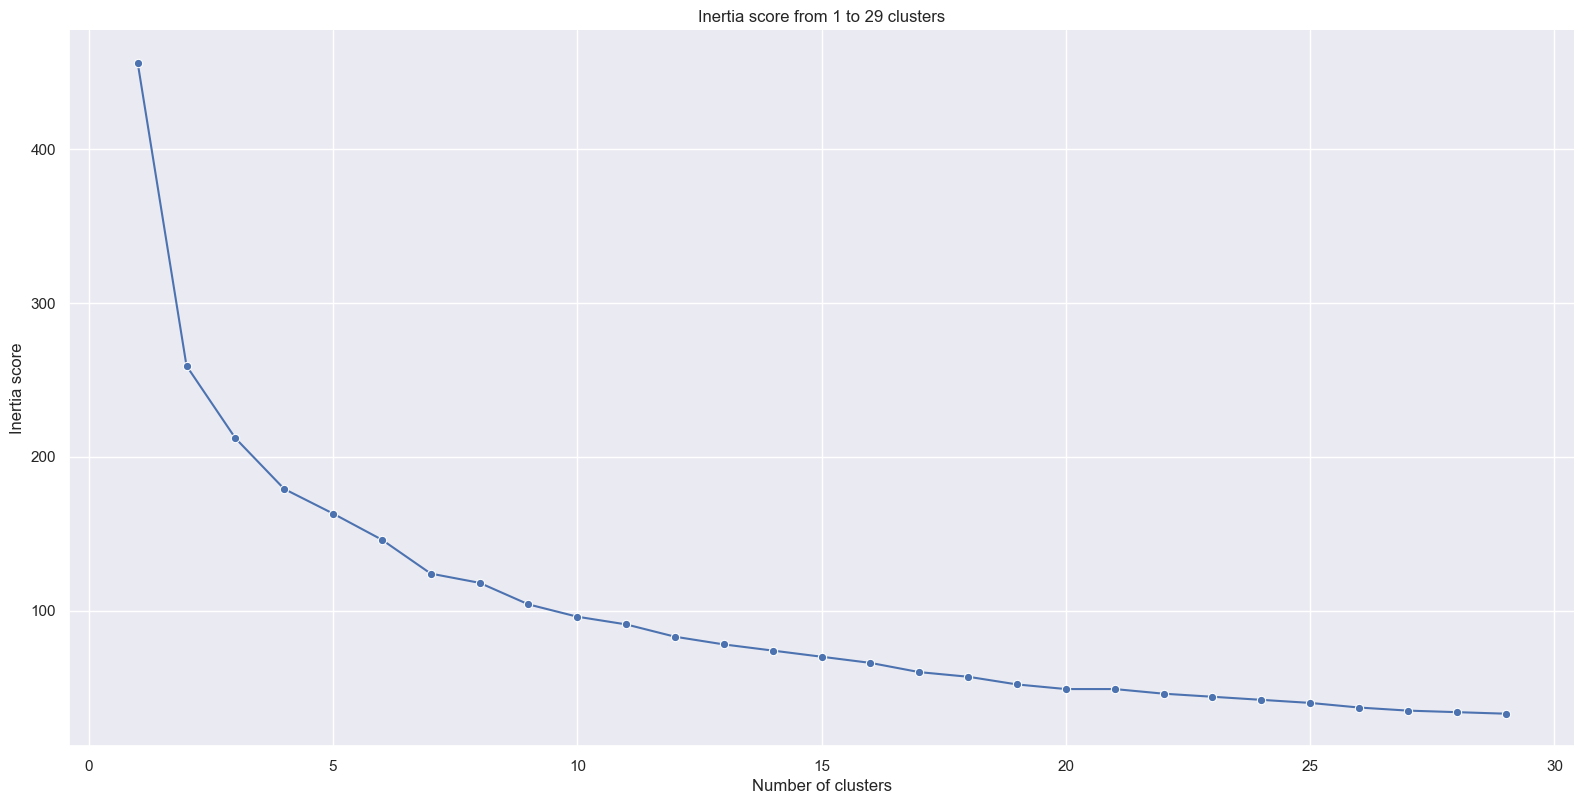

In [61]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1,max_k),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia score from 1 to {max_k-1} clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia score")
);

In [ ]:
# Silhouette

seed = 123
max_k = 30

# Create an empty list to store the silhouette scores
sil_scores = []

for j in range(2, max_k):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=j,
                    n_init="auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(cluster1_scaled)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(cluster1_scaled, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

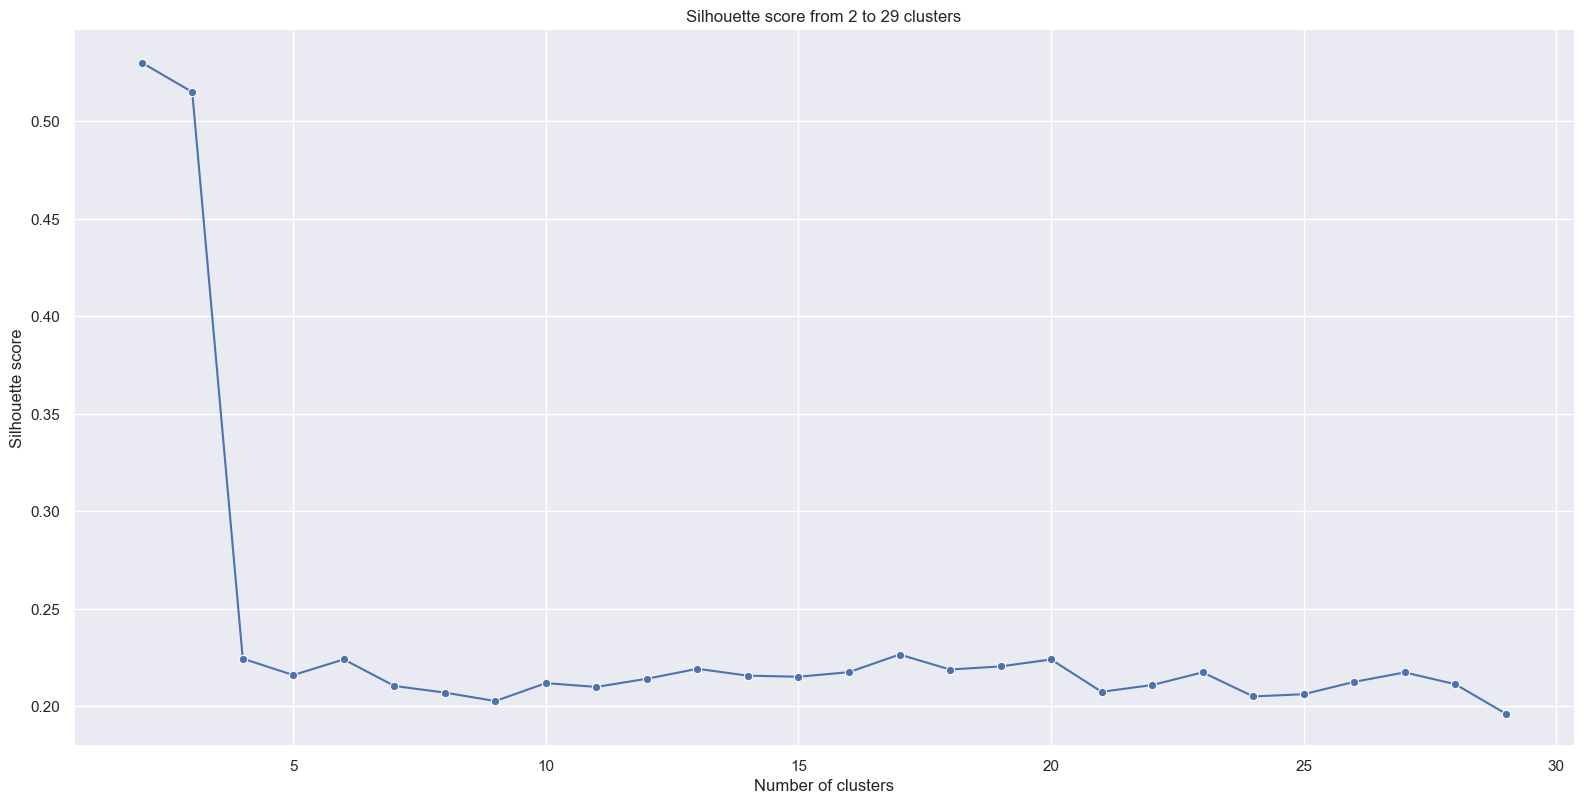

In [64]:
sns.set_theme(style='darkgrid')

(
sns.relplot(y=sil_scores,
            x=range(2,max_k),
            kind='line',
            marker='o',
            height = 8,
            aspect=2)
.set(title=f"Silhouette score from 2 to {max_k-1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

k=3 seems a reasonable number of subcluster for cluster 1

---
## Create Spotify Playlists

using spotipy

In [65]:
n_clusters = 25
spotifyObject = spotify_gen_object()

playlist_collection = {}
for i in range(n_clusters):  # This range must match the number of clusters
    playlist_name = f'my_playlist_cluster_{i}'  # Here, we will create simple playlist names indicating which cluster created the playlist
    playlist_description= 'this is a test list'
    playlist_id = spotifyObject.user_playlist_create(user=client_username,
                                                     name=playlist_name,
                                                     public=True,
                                                     description=playlist_description)['id']
    id_list = list(songs_df_clustered.loc[songs_df_clustered["cluster"] == i]
                            .sample(stats.cluster_count.min())  # max 100 songs per query. I go with the smallest cluster length
                            .id
                   )
     # Spotify needs certain text wrappers around ID numbers to identify the target as a track, a playlist, etc.
    uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
    spotifyObject.user_playlist_add_tracks(user=client_username,playlist_id=playlist_id,tracks=uris)
    playlist_collection[playlist_name] = playlist_id

In [66]:
# Playlist IDs can be saved in a file for later
with open("./playlists.pkl", "wb") as f:
    pickle.dump(playlist_collection, f)

In [ ]:
# overwriting existing playlists
n_clusters = 25
spotifyObject = spotify_gen_object()

with open("./playlists.pkl", "rb") as f:
    playlist_collection = pickle.load(f)

for i in range(n_clusters):  # This range must match the number of clusters 

    playlist_id = playlist_collection[f"my_playlist_cluster_{i}"] # We now replace the 5 songs in playlist 0 with 10 different songs

    id_list = list(songs_df_clustered.loc[songs_df_clustered["cluster"] == i]
                        .sample(stats.cluster_count.min())  # take the smallest possible sample
                        .id
                )
    uris = [f'spotify:track:{str(id).strip()}' for id in id_list]

    spotifyObject.user_playlist_replace_tracks(user=client_username, playlist_id=playlist_id, tracks=uris)

In [88]:
# create a file with all spotify id as a link
with open("./playlists.pkl", "rb") as f:
    playlist_collection = pickle.load(f)
playlists_df = pd.DataFrame.from_dict(playlist_collection, orient="index", columns=["id"]).reset_index(names="cluster")

playlists_df["link"] = [f"https://open.spotify.com/playlist/{id}" for id in playlists_df.id]


playlists_df.to_csv("playlists.csv", index=False)

# https://open.spotify.com/playlist/51DhD4doMhhh5TjBAasX1c


max number of tracks per request=100

---
## Find Genres using LLM

In [23]:
artists = pd.DataFrame(songs_df_clustered.artist.str.strip().drop_duplicates())

#### OpenAi Approach 

In [17]:
# Connect to OpenAI 
client = openai.OpenAI(api_key=openai_token)  

# A function that serves to communicate with an AI assistant, specialized in music  
def ask_AI(prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are are a music expert"},
        {"role": "user", "content": prompt}
    ]
    )
    return(completion.choices[0].message.content)

In [37]:
ask_AI("whats the 3 top genres of this music artist? state only three genres, devided by comma, without addititional info. artist: Belle & Sebastian")

Indie pop, indie rock, chamber pop.


In [21]:
artist = ["Belle & Sebastian", "Tristan Murail", "Kurt Elling"]
ask_AI(f"whats the general genre of this music artist? state only one genre, without addititional info. artist: {artist[2]}")

'Jazz'

In [18]:
# this function calls OpenAI LLM to assign three genres to each artist. It takes the artist df including a column "artist"
def artist_genre(artist_df):
       
    genre_list = []

    for artist in artist_df["artist"]:
        response = ask_AI(f"whats the 3 top genres of this music artist? state only three genres, devided by comma, without addititional info. artist: {artist}")
        genre_list.append(response)

    artist_df["genre"] = genre_list

    return(artist_df)

# assign only one genre to each artist
def artist_genre_gen(artist_df):
       
    genre_list = []

    for artist in artist_df["artist"]:
        response = ask_AI(f"whats the general genre of this music artist? state only one genre, without addititional info. artist: {artist}")
        genre_list.append(response)

    artist_df["genre"] = genre_list

    return(artist_df)

In [51]:
# run function to find 3 genres per artist
artists_df = artist_genre(artists)
artists_df.rename(columns={"genre":"genres"}, inplace=True)

In [ ]:
# run function to find one genre per artist
artists_df_gen = artist_genre_gen(artists)

In [133]:
# merge genres 
artists_df = artists_df.merge(artists_df_gen, "left", "artist")

In [36]:
# save as csv
artists_df.to_csv("artists.csv", index=False)

In [137]:
# read from csv
artists_df = pd.read_csv("artists.csv")

In [144]:
# Clean genre labels
import re

def capitalize_word(match):
    word = match.group(0)
    special_cases = ["R&B", "MPB"]
    if word in special_cases or word.isupper():
        return word
    return word.capitalize()

# Regular expression pattern to match words
pattern = re.compile(r'\b[a-zA-Z]+\b')

# Function to apply the pattern and capitalize words in a string
def capitalize_string(text):
    return pattern.sub(capitalize_word, text)

# Apply the function to each entry in genre and genres columns
artists_df['genres'] = artists_df['genres'].apply(capitalize_string)
artists_df['genre'] = artists_df['genre'].apply(capitalize_string)

### Genre Cloud

In [146]:
# create merged dataframe with all clustered songs and Genres 
songs_df_clustered_genres = songs_df_clustered.merge(artists_df, on="artist", how="left")

In [241]:
# Song Count per Genre
songs_df_clustered_genres.value_counts("genre").head(50)

genre
Pop                    835
Death Metal            774
Electronic             451
Classical              294
Jazz                   280
Reggaeton              257
Metal                  219
Rock                   206
RB                     138
Hip Hop                129
Hiphop                 123
Indie Pop               88
Reggae                  86
Folk                    85
Indie Rock              73
Ambient                 66
Soul                    57
Gospel                  50
Kpop                    48
Drum And Bass           47
House                   46
Bossa Nova              45
Country                 43
Thrash Metal            41
Indie Folk              36
Samba                   36
Baroque                 32
EDM                     31
Grindcore               29
Black Metal             29
Alternative             29
Dance                   25
Rockabilly              24
Blues                   17
Rocknroll               17
Progressive Metal       16
Dancehall             

there is a bias in the dataset towards Metal and Pop Songs

In [157]:
# Genre Count in on cluster (cluster 8)
songs_df_clustered_genres.loc[songs_df_clustered_genres.cluster == 8].value_counts("genre")

genre
Death Metal            63
Electronic             34
Metal                  13
Black Metal             5
Drum And Bass           5
Melodic Death Metal     4
Electro House           3
Indie Rock              2
Progressive Metal       2
Indie Pop               2
Grindcore               2
Thrash Metal            2
Dancehall               1
EDM                     1
Pop                     1
Progressive House       1
Doom Metal              1
Rock                    1
dtype: int64

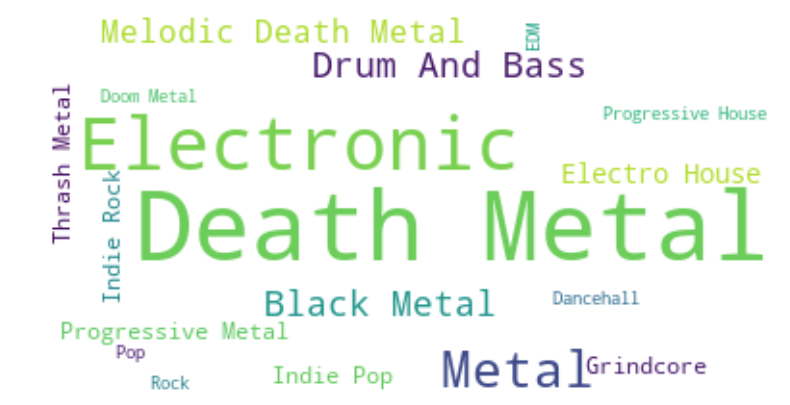

In [195]:
# Visualizing Genre Frequency of selected clusters
genres_freq = songs_df_clustered_genres.loc[songs_df_clustered_genres.cluster == 8,"genre"].value_counts().to_dict()

wordcloud = WordCloud(
    # width=800,
    # height=400,
    background_color='white',
    max_words=100,
    max_font_size=50
).generate_from_frequencies(genres_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()